# CB Model

The following tries to reproduce Fig 10 from [Hawkes, Jalali, Colquhoun (1992)](http://dx.doi.org/10.1098/rstb.1992.0116). First we create the $Q$-matrix for this particular model from [Hawkes, Jalali, Colquhoun (1992)](http://dx.doi.org/10.1098/rstb.1992.0116). First we create the $Q$-matrix for this particular model.

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from dcprogs.likelihood import QMatrix

tau = 0.2
qmatrix = QMatrix([ [-2,    1,   1,    0], 
                    [ 1, -101,   0,  100], 
                    [50,    0, -50,    0],
                    [ 0,  5.6,   0, -5.6]], 1)

We then create a function to plot each exponential component in the asymptotic expression. An explanation on how to get to these plots can be found in the **CH82** notebook.

In [4]:
from dcprogs.likelihood._methods import exponential_pdfs

def plot_exponentials(qmatrix, tau, x0=None, x=None, ax=None, nmax=2, shut=False):
    from dcprogs.likelihood import missed_events_pdf
    from dcprogs.likelihood._methods import exponential_pdfs
    if ax is None: 
        fig, ax = plt.subplots(1,1)
    if x is None: 
        x = np.arange(0, 5*tau, tau/10)
    if x0 is None: 
        x0 = x
    pdf = missed_events_pdf(qmatrix, tau, nmax=nmax, shut=shut)
    graphb = [x0, pdf(x0+tau), '-k']
    functions = exponential_pdfs(qmatrix, tau, shut=shut)
    plots = ['.r', '.b', '.g']
    together = None
    for f, p in zip(functions[::-1], plots):
        if together is None: 
            together = f(x+tau)
        else: 
            together = together + f(x+tau)
        graphb.extend([x, together, p])

    ax.plot(*graphb)

For practical reasons, we plot the excess shut-time probability densities in the graph below. In all other particulars, it should reproduce Fig. 10 from [Hawkes, Jalali, Colquhoun (1992)](http://dx.doi.org/10.1098/rstb.1992.0116)

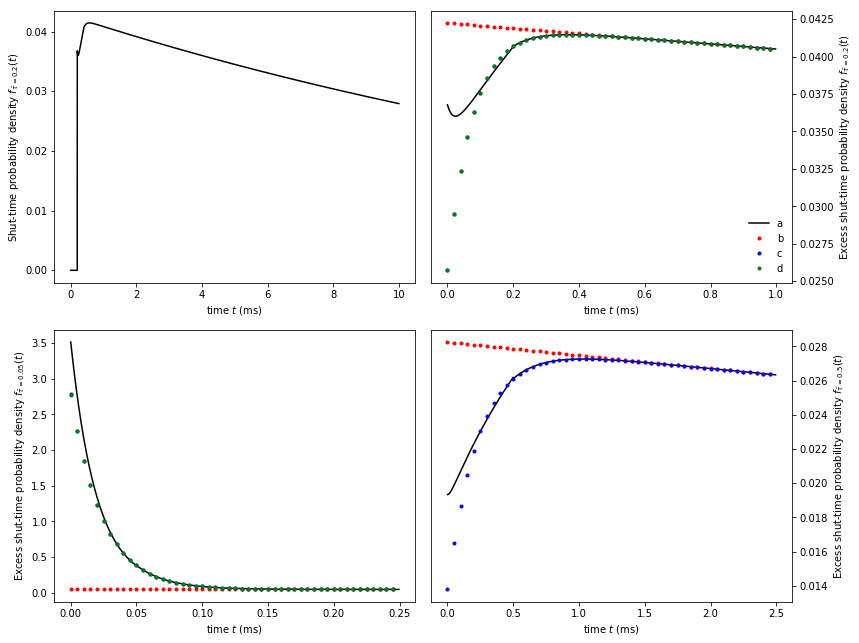

In [5]:
from dcprogs.likelihood import missed_events_pdf

fig, ax = plt.subplots(2,2, figsize=(12,9))
x = np.arange(0, 10, tau/100)
pdf = missed_events_pdf(qmatrix, 0.2, nmax=2, shut=True)
ax[0,0].plot(x, pdf(x), '-k')
ax[0,0].set_xlabel('time $t$ (ms)')
ax[0,0].set_ylabel('Shut-time probability density $f_{\\bar{\\tau}=0.2}(t)$')

ax[0,1].set_xlabel('time $t$ (ms)')
tau = 0.2
x, x0 = np.arange(0, 5*tau, tau/10.0), np.arange(0, 5*tau, tau/100) 
plot_exponentials(qmatrix, tau, shut=True, ax=ax[0,1], x=x, x0=x0)
ax[0,1].set_ylabel('Excess shut-time probability density $f_{{\\bar{{\\tau}}={tau}}}(t)$'.format(tau=tau))
ax[0,1].set_xlabel('time $t$ (ms)')
ax[0,1].yaxis.tick_right()
ax[0,1].yaxis.set_label_position("right")

tau = 0.05
x, x0 = np.arange(0, 5*tau, tau/10.0), np.arange(0, 5*tau, tau/100) 
plot_exponentials(qmatrix, tau, shut=True, ax=ax[1,0], x=x, x0=x0)
ax[1,0].set_ylabel('Excess shut-time probability density $f_{{\\bar{{\\tau}}={tau}}}(t)$'.format(tau=tau))
ax[1,0].set_xlabel('time $t$ (ms)')

tau = 0.5
x, x0 = np.arange(0, 5*tau, tau/10.0), np.arange(0, 5*tau, tau/100) 
plot_exponentials(qmatrix, tau, shut=True, ax=ax[1,1], x=x, x0=x0)
ax[1,1].set_ylabel('Excess shut-time probability density $f_{{\\bar{{\\tau}}={tau}}}(t)$'.format(tau=tau))
ax[1,1].set_xlabel('time $t$ (ms)')
ax[1,1].yaxis.tick_right()
ax[1,1].yaxis.set_label_position("right")
ax[0,1].legend(['a','b','c','d'], loc='best')
fig.tight_layout()

In [7]:
from dcprogs.likelihood import DeterminantEq, find_root_intervals, find_lower_bound_for_roots
from numpy.linalg import eig
tau = 0.5
determinant = DeterminantEq(qmatrix, tau).transpose()
x = np.arange(-100, -3, 0.1)

matrix = qmatrix.transpose()
qaffa = np.array(np.dot(matrix.af, matrix.fa), dtype=np.float128)
aa = np.array(matrix.aa, dtype=np.float128)

def anaH(s):
    from numpy.linalg import det 
    from numpy import identity, exp
    arg0 = 1e0/np.array(-2-s, dtype=np.float128)
    arg1 = np.array(-(2+s) * tau, dtype=np.float128)
    return qaffa * (exp(arg1) - np.array(1e0, dtype=np.float128)) * arg0 + aa

def anadet(s):
    from numpy.linalg import det 
    from numpy import identity, exp
    s = np.array(s, dtype=np.float128)
    matrix = s*identity(qaffa.shape[0], dtype=np.float128) - anaH(s)
    return matrix[0,0] * matrix[1, 1] * matrix[2, 2]          \
           + matrix[1,0] * matrix[2, 1] * matrix[0, 2]        \
           + matrix[0,1] * matrix[1, 2] * matrix[2, 0]        \
           - matrix[2,0] * matrix[1, 1] * matrix[0, 2]        \
           - matrix[1,0] * matrix[0, 1] * matrix[2, 2]        \
           - matrix[2,1] * matrix[1, 2] * matrix[0, 0]   

x = np.arange(-100, -3, 1e-2)
# For some reason gcc builds with regular doubles have trouble finding the
# roots with alpha=2.0 the default so override it here

print("Lower bound for all roots is {}".format(find_lower_bound_for_roots(determinant, alpha=1.9)))
print(eig(np.array(anaH(-160 ), dtype='float64'))[0])
print(anadet(-104))

Lower bound for all roots is -126.51309385718378
[  0.00000000e+00   6.57926167e+33  -5.60000000e+00]
0.0
